In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load dataset from Google Drive

In [26]:
matrix_2d  = xr.open_dataarray("path/samples_200_Dummy.nc")
matrix_1d = matrix_2d.stack(z=("nodes","DoFs"))

matrix1  = xr.open_dataarray("path/samples_200_Dummy.nc") 
sims_a,times, DoFs, node_ID = matrix_2d.indexes.values()

matrix_conv1d = (matrix_1d) / np.max(matrix_1d) ## normalise the dataset by dividing max value
matrix_conv2d = (matrix_2d) / np.max(matrix_2d) ## normalise the dataset by dividing max value


### INPUT FEM PARAMETERS
inputParameter = pd.read_csv("path/Inputs_data_200.csv") ## input fem parameters


In [6]:
import yaml

with open(r'path/data.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    inputParameter =yaml.load(file)
    initial = inputParameter['initialise']
    Autoencoder_paramters = inputParameter['Autoencoder_paramters']

    print(initial,Autoencoder_paramters)

{'DOF': 3, 'nodes': 7441, 'time_states': 32, 'split_size': 0.2, 'simulation': 50} {'latent': 8, 'lr': 0.0001, 'epoch': 1000, 'batchsize': 7, 'architecture': 4, 'model': 'conv1d', 'kernal': 3, 'padding': 'valid', 'activation': 'relu', 'convolution_layer1': 1500, 'convolution_layer2': 750, 'convolution_layer3': 375, 'convolution_layer4': 150, 'convolution_layer5': 0}


In [7]:
input_matrix_1D = initial['time_states'],initial['nodes']*initial['DOF']

In [8]:
if Autoencoder_paramters['architecture'] == 1 :  ## if nodes <100 
        conv1,conv2,conv3,conv4,conv5 = Autoencoder_paramters['convolution_layer1'],Autoencoder_paramters['convolution_layer2'],Autoencoder_paramters['convolution_layer3'],Autoencoder_paramters['convolution_layer4'],Autoencoder_paramters                                                                                ['convolution_layer5']
        print(conv1,conv2,conv3,conv4,conv5)

elif Autoencoder_paramters['architecture'] ==2 or 4:     ## if nodes greater than 1000 and less than 3000
        conv1,conv2,conv3,conv4,conv5 = Autoencoder_paramters['convolution_layer1'],Autoencoder_paramters['convolution_layer2'],Autoencoder_paramters['convolution_layer3'],Autoencoder_paramters['convolution_layer4'],Autoencoder_paramters                                                                                ['convolution_layer5']
                                            
        print(conv1,conv2,conv3,conv4,conv5)

elif Autoencoder_paramters['architecture']==3 or 5:       ## if nodes greater than 3000 and less than 5000
        conv1,conv2,conv3,conv4,conv5 = Autoencoder_paramters['convolution_layer1'],Autoencoder_paramters['convolution_layer2'],Autoencoder_paramters['convolution_layer3'],Autoencoder_paramters['convolution_layer4'],Autoencoder_paramters                                                                                ['convolution_layer5']
        print(conv1,conv2,conv3,conv4,conv5)

1500 750 375 150 0


## Split the dataset for Trainig and testing

In [9]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
from sklearn.model_selection import train_test_split

## SPLIT THE AUTOENCODER DATASET FOR TRAINIG AND TESTING

class Traintestsplit_AE:
    
    
    """
    X - Input FEM parameters
    Y1 - convolutional 1d matrix
    Y2 - convolutional 2d matrix
    model - either convolutional 1d or 2d
    Returns: train_test split for selected model

    """
    def __init__(self,inp,conv1d,conv2d,model,simulation,nodes,split_size):
        #super(Traintestsplit_AE, self).__init__()
        self.inp  = inp
        self.conv1d = conv1d
        self.conv2d = conv2d
        self.model = model
        self.simulation = simulation
        self.nodes = nodes
        self.split_size = split_size
        #self.samples = self.simulation*(1-self.split_size)
        
    def call(self):                
        if self.model == 'conv1d':                      # if model is convolutional 1d
            Y1 =self.conv1d                      ## DISPLACEMENT MATRIX FOR CONV 1D
            
                        
            X_train, X_test, Y_train, Y_test = train_test_split(self.inp,Y1,random_state=42,
                                                                 test_size=self.split_size,shuffle = True)
            
            X_train = X_train.iloc[:int((self.simulation)*(1-self.split_size)),:]
            X_test  = X_test.iloc[:int((self.simulation)*(self.split_size)),:]
            Y_train = Y_train[:int((self.simulation)*(1-self.split_size)),:,:self.nodes*3]
            Y_test  = Y_test[:int((self.simulation)*(self.split_size)),:,:self.nodes*3]
            
            return X_train,X_test,Y_train,Y_test


        elif self.model =='conv2d':                            # else model is convolutional 2d
            Y2 = self.conv2d                                   ## DISPLACEMENT MATRIX FOR CONV 2D  
            
            X_train, X_test, Y_train, Y_test = train_test_split(self.inp,Y2,random_state=42,
                                                                 test_size=0.20,shuffle = True)

            X_train = X_train.iloc[:int((self.simulation)*(1-self.split_size)),:]
            X_test  = X_test.iloc[:int((self.simulation)*(self.split_size)),:]
            Y_train  = Y_train[:int((self.simulation)*(1-self.split_size)),:,:self.nodes*3,:]
            Y_test  = Y_test[:int((self.simulation)*(self.split_size)),:,:self.nodes*3,:] 

            return X_train,X_test,Y_train,Y_test


In [10]:
X = Traintestsplit_AE(input_fem,matrix_conv1d ,matrix_conv2d,Autoencoder_paramters['model'],
             initial['simulation'],initial['nodes'],initial['split_size'])
                                                                

X_train,X_test,Y_train,Y_test = X.call()
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((40, 4), (10, 4), (40, 32, 22323), (10, 32, 22323))

## LOAD THE AUTOENCODER MODEL

In [12]:
import tensorflow as tf
# Check its architecture
saved_model_AE = tf.keras.models.load_model('path/model1_LT{}_nds{}_batch{}_sim{}_conv1{}_epoch{}'.format(Autoencoder_paramters['latent'],
    initial['nodes'],Autoencoder_paramters['batchsize'],initial['simulation'],conv1,Autoencoder_paramters['epoch']))

saved_model_AE.summary()


#Evaluating the Model using the Test Set

Y_test = np.array(Y_test)
test_loss, test_acc = saved_model_AE.evaluate(Y_test,  Y_test, verbose=1)
print(Y_test.shape)
print('\nTest accuracy:', test_acc)

Model: "conv_autoencoder_1d_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 8)                 104848583 
_________________________________________________________________
sequential_9 (Sequential)    (None, 32, 22323)         104871348 
Total params: 209,719,931
Trainable params: 209,719,931
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 5s 5s/step - loss: 5.5604e-05 - accuracy: 0.4906
(10, 32, 22323)

Test accuracy: 0.4906249940395355


In [13]:
saved_model_AE.encoder.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 30, 1500)          100455000 
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 28, 750)           3375750   
_________________________________________________________________
average_pooling1d_7 (Average (None, 14, 750)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 12, 375)           844125    
_________________________________________________________________
average_pooling1d_8 (Average (None, 6, 375)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 4, 150)            168900    
_________________________________________________________________
flatten_4 (Flatten)          (None, 600)              

In [14]:
saved_model_AE.decoder.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 600)               5400      
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 150)            0         
_________________________________________________________________
conv1d_transpose_15 (Conv1DT (None, 6, 375)            169125    
_________________________________________________________________
up_sampling1d_7 (UpSampling1 (None, 12, 375)           0         
_________________________________________________________________
conv1d_transpose_16 (Conv1DT (None, 14, 750)           844500    
_________________________________________________________________
up_sampling1d_8 (UpSampling1 (None, 28, 750)           0         
_________________________________________________________________
conv1d_transpose_17 (Conv1DT (None, 30, 1500)         

In [15]:
## predict the test data and then decode 
#decoded = saved_model_AE.predict(Y_test)
latent_test = saved_model_AE.encoder.predict(Y_test)
latent_train = saved_model_AE.encoder.predict(Y_train)### This is for training with FEM parameters

## DATASET FOR REGRESSION MODEL

x datasets are the FEM Parameters and y datasets are the latent space from autoencoder

In [16]:
def split_regression(X_train,latent_train):
    
    
    """
    X_train - Input FEM parameters
    latent_train - targets
    Returns: train_validation split for regression

    """
    x_train, x_val, y_train, y_val = train_test_split(X_train,latent_train,random_state=42,
                                                                 test_size=0.20,shuffle = True)
    
    return x_train, x_val, y_train, y_val

In [17]:

x_train, x_val, y_train, y_val = split_regression(X_train,latent_train)

x_train.shape,y_train.shape,x_val.shape,y_val.shape



((32, 4), (32, 8), (8, 4), (8, 8))

## Random forest Regressor

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rfr = RandomForestRegressor()

params_rfr = {'n_estimators':[10,20,30,40,50,100],
 'criterion':['mae'],
 'max_depth':[5,10,20,25],
 'min_samples_split':[2,4,6,8,10],
 'min_samples_leaf':[2,4,6,8,10],  
 'max_features':['auto'],
 'warm_start':['warm_start'],
 'oob_score':['True','False'],
 'bootstrap':['True','False']}

rs_rfr = RandomizedSearchCV(rfr, params_rfr, cv=3, return_train_score=False, n_iter=10)

rfr_rsCV = rs_rfr.fit(X_train, latent_train)
print(rfr_rsCV.best_params_)
print(pd.DataFrame(rfr_rsCV.cv_results_))

rfr_best_esti = rfr_rsCV.best_estimator_
print(rfr_best_esti)





/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

{'warm_start': 'warm_start', 'oob_score': 'True', 'n_estimators': 40, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 25, 'criterion': 'mae', 'bootstrap': 'False'}
   mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0       0.065453      0.003875  ...        0.163189               10
1       0.100248      0.003299  ...        0.084390                2
2       0.074650      0.003516  ...        0.074674                3
3       0.037124      0.000748  ...        0.168382                8
4       0.165313      0.005610  ...        0.098224                6
5       0.091181      0.000265  ...        0.085198                4
6       0.087018      0.000741  ...        0.089241                5
7       0.048626      0.002171  ...        0.153096                9
8       0.022134      0.002693  ...        0.076026                7
9       0.079502      0.002561  ...        0.090742                1

[10 rows x 20 columns]
RandomForestRegre

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [20]:
#%% Best Fit
### 

RFR = RandomForestRegressor(bootstrap='False', ccp_alpha=0.0, criterion='mae',
                      max_depth=25, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=None, oob_score='True',
                      random_state=None, verbose=0, warm_start='warm_start')

RFR.fit(X_train, latent_train)

RandomForestRegressor(bootstrap='False', ccp_alpha=0.0, criterion='mae',
                      max_depth=25, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=None, oob_score='True',
                      random_state=None, verbose=0, warm_start='warm_start')

In [21]:
Y_pred_RFR = RFR.predict(X_test)

In [22]:
decoded_predict_RF = saved_model_AE.decoder.predict(Y_pred_RFR)
decoded_predict_RF = decoded_predict_RF * (np.max(matrix_1d).values)


In [23]:
## convert 4d matrix to 3d for conv2d 
test_data = (np.array(Y_test)) *np.max(matrix_1d).values

In [24]:
## convert matrix 3d to 4d for plots
if Autoencoder_paramters['model'] =='conv1d':
    test_data_plots = np.array(Y_test).reshape(Y_test.shape[0],Y_test.shape[1],
                                                      initial['nodes'],3) *(np.max(matrix_1d).values)
    
    decoded_predict_RanForest = np.array(decoded_predict_RF).reshape(decoded_predict_RF.shape[0],
                               decoded_predict_RF.shape[1],initial['nodes'],3) 
                                                      

In [27]:
## Convert array to Dataframe
sims, states, DoFs, nodes = matrix_2d.indexes.values()
test_idx = np.array(X_test.index)
node_idx = np.array(nodes[0:initial['nodes']])


test_pred_RF = xr.DataArray(decoded_predict_RanForest, dims = ["t_sims","t_states","Nds","DoFs"],
                         coords = {"t_sims":test_idx,                              
                                   "Nds": node_idx,
                                   "DoFs": DoFs})

## Visulizing the performance of ML predicted versus FE simulation

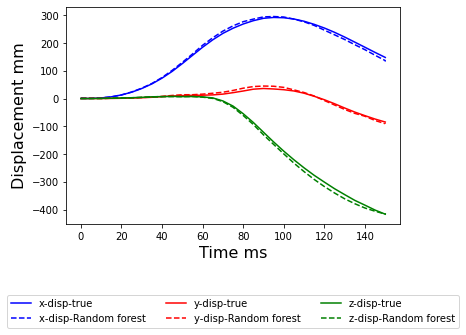

In [29]:
plt.figure()
Nnodeno = 1002713

plt.plot(states, matrix_2d.sel(sims = test_idx[-1], nodes = Nnodeno, DoFs = 'x_disp'),'b',label='x-disp-true')
plt.plot(states, test_pred_RF.sel(t_sims = test_idx[-1], Nds = Nnodeno, DoFs = 'x_disp'),'--b',label='x-disp-Random forest')

plt.plot(states, matrix_2d.sel(sims = test_idx[-1], nodes = Nnodeno, DoFs = 'y_disp'),'r',label='y-disp-true')
plt.plot(states, test_pred_RF.sel(t_sims = test_idx[-1], Nds = Nnodeno, DoFs = 'y_disp'),'--r',label='y-disp-Random forest')

plt.plot(states, matrix_2d.sel(sims = test_idx[-1], nodes = Nnodeno, DoFs = 'z_disp'),'g',label='z-disp-true')
plt.plot(states, test_pred_RF.sel(t_sims = test_idx[-1], Nds = Nnodeno, DoFs = 'z_disp'),'--g',label='z-disp-Random forest')

plt.xlabel('Time ms', fontsize = 16)
plt.ylabel('Displacement mm', fontsize = 16)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5), ncol=3)
plt.savefig('node_1002713_sim45_7441.jpeg')

## Mean distance error for True and ML predicted displacement

In [31]:
mean_dist_nds_test = []
for j in range(0,X_test.shape[0]):
    dist_nds = []
    pred = decoded_predict_RF[j,:,:].reshape(len(times),3,initial['nodes'])
    true = test_data[j,:,:].reshape(len(times),3,initial['nodes'])
    for k in range(initial['nodes']):
        squared_dist = np.sum((true[:,:,k]-pred[:,:,k])**2, axis=1)
        dist = np.sqrt(squared_dist)
        dist_nds.append(dist)
    
    mean_dist_nds = np.array(dist_nds).mean(axis = 0)
    mean_dist_nds_test.append(mean_dist_nds)

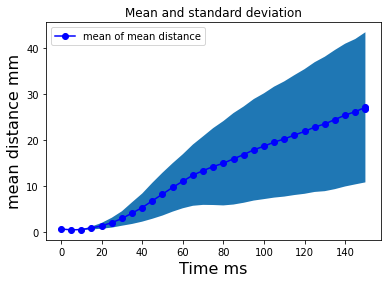

In [32]:
mean_dist_mean = np.array(mean_dist_nds_test).mean(axis=0)
mean_dist_std = np.array(mean_dist_nds_test).std(axis=0)

plt.figure()
plt.title("Mean and standard deviation")
plt.xlabel('Time ms', fontsize = 16)
plt.ylabel('mean distance mm', fontsize = 16)
plt.plot(times,mean_dist_mean,'o-', color = "b", label= "mean of mean distance")
plt.fill_between(times, mean_dist_mean-mean_dist_std, mean_dist_mean+mean_dist_std)
plt.legend(loc='upper left')

In [33]:
## Mean absolute error

from sklearn.metrics import mean_absolute_error
mae = []
for j in range(0,X_test.shape[0]):
    MAE =  mean_absolute_error(test_data[j,:,:], decoded_predict_RF[j,:,:])#,multioutput='raw_values')
    mae.append(MAE)
print(mae)

[6.180298313176433, 4.339653038348473, 6.519543485655929, 8.421362976990459, 4.340210032841543, 8.446114663708896, 14.59810685983866, 3.5978057702803863, 2.101006503011878, 3.0618007434306307]


In [41]:
# Euclidean distance error

euclidean_error = mean_Ecd_dist_sim

NameError: ignored

## Visualization of Each and every layer in convolutiona encoder

In [34]:
successive_outputs_encoder = [layer.output for layer in saved_model_AE.encoder.layers[:]]


inputs = tf.keras.layers.Input(shape=(initial['time_states'],initial['nodes']*initial['DOF']))
visualization_model_encoder = tf.keras.models.Model(inputs =saved_model_AE.encoder.input, outputs = successive_outputs_encoder)
visualization_model_encoder.summary(),inputs.shape

x   = np.array(Y_test)

successive_feature_maps = visualization_model_encoder.predict(x)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 22323)]       0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 30, 1500)          100455000 
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 28, 750)           3375750   
_________________________________________________________________
average_pooling1d_7 (Average (None, 14, 750)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 12, 375)           844125    
_________________________________________________________________
average_pooling1d_8 (Average (None, 6, 375)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 4, 150)            168900

In [35]:
input = Y_test

conv1 = successive_feature_maps[-8]
conv2 = successive_feature_maps[-7]
pool1 = successive_feature_maps[-6]
conv3 = successive_feature_maps[-5]
pool2 = successive_feature_maps[-4]
conv4 = successive_feature_maps[-3]
Flatten = successive_feature_maps[-2]
dense = successive_feature_maps[-1]

 ...]

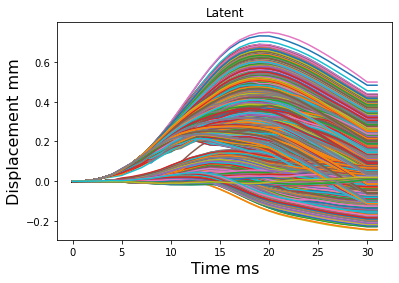

In [36]:
## Visualize the displacement matrix for first 1000 nodes
sim_num = 0
plt.figure()
plt.title('Latent')
plt.xlabel('Time ms', fontsize = 16)
plt.ylabel('Displacement mm', fontsize = 16)
plt.plot(input[sim_num,:,0:3000],'-',label='Input displacement')  

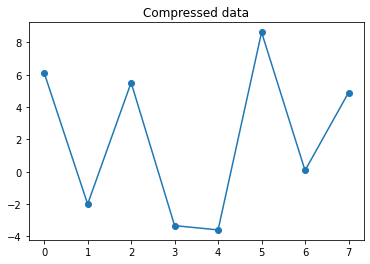

In [37]:
# Visulise the latent space
plt.figure()
plt.title('Compressed data')
plt.plot(dense[0,:],'o-',label='Latent visualisation')  

## Visualization of convolutional decoder

In [38]:
successive_outputs_decoder = [layer.output for layer in saved_model_AE.decoder.layers[:]]

#visualization_model = Model(img_input, successive_outputs)

#inputs = tf.keras.layers.Input(shape=(initial['time_states'],initial['nodes']*initial['DOF']))
visualization_model = tf.keras.models.Model(inputs =saved_model_AE.decoder.input, outputs = successive_outputs_decoder)
visualization_model.summary(),inputs.shape

latent   = np.array(dense)

feature_maps_decoder = visualization_model.predict(latent)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9_input (InputLayer)   [(None, 8)]               0         
_________________________________________________________________
dense_9 (Dense)              (None, 600)               5400      
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 150)            0         
_________________________________________________________________
conv1d_transpose_15 (Conv1DT (None, 6, 375)            169125    
_________________________________________________________________
up_sampling1d_7 (UpSampling1 (None, 12, 375)           0         
_________________________________________________________________
conv1d_transpose_16 (Conv1DT (None, 14, 750)           844500    
_________________________________________________________________
up_sampling1d_8 (UpSampling1 (None, 28, 750)           0   

In [39]:
deconvolution_layer4 = feature_maps_decoder[-1]
deconvolution_layer3 = feature_maps_decoder[-2]
upsampling_layer2 = feature_maps_decoder[-3]
deconvolution_layer2 = feature_maps_decoder[-4]
upsampling_layer1 = feature_maps_decoder[-5]
deconvolution_layer1 = feature_maps_decoder[-6]

 ...]

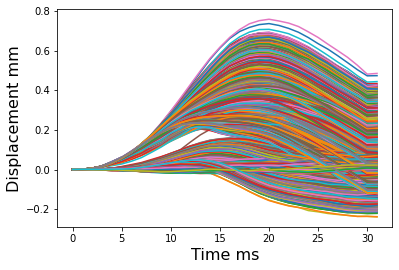

In [40]:
## Visualize the AE-GPR predicted displacements
plt.figure()
#plt.title('')
plt.xlabel('Time ms', fontsize = 16)
plt.ylabel('Displacement mm', fontsize = 16)
plt.plot(deconvolution_layer4[0,:,0:3000],'-',label='Input displacement')  